# Image Classification with Transfer Learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = "https://pytorch.tips/bee-zip"

with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall("./data")

In [2]:
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
train_dataset = datasets.ImageFolder(
    root="data/hymenoptera_data/train", transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root="data/hymenoptera_data/val", transform=val_transforms
)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=4
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, shuffle=True, num_workers=4
)

In [7]:
model = models.resnet18(pretrained=True)
print(model.fc)

num_fters = model.fc.in_features
model.fc = nn.Linear(num_fters, 2)
print(model.fc)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s] 

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


In [13]:
from torch.optim.lr_scheduler import StepLR

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
from tqdm import tqdm

NUM_EPOCHS = 25
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    running_loss = 0.0
    running_correct = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() / inputs.size(0)
        running_correct += torch.sum(preds == labels) / inputs.size(0)

    exp_lr_scheduler.step()

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_correct / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_correct = 0.0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() / inputs.size(0)
        running_correct += torch.sum(preds == labels) / inputs.size(0)

    val_epoch_loss = running_loss / len(val_loader)
    val_epoch_acc = running_correct / len(val_loader)

    print(
        "Train: Loss: {:.4f} Acc: {:.4f}"
        " Val: Loss: {:.4f}"
        " Acc: {:.4f}".format(
            train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc
        )
    )

  4%|▍         | 1/25 [00:02<00:53,  2.22s/it]

Train: Loss: 0.0364 Acc: 0.8871 Val: Loss: 0.0202 Acc: 0.9688


  8%|▊         | 2/25 [00:04<00:46,  2.03s/it]

Train: Loss: 0.0497 Acc: 0.8266 Val: Loss: 0.1421 Acc: 0.8813


 12%|█▏        | 3/25 [00:06<00:43,  1.99s/it]

Train: Loss: 0.0272 Acc: 0.9274 Val: Loss: 0.0220 Acc: 0.9438


 16%|█▌        | 4/25 [00:07<00:41,  1.96s/it]

Train: Loss: 0.0254 Acc: 0.8992 Val: Loss: 0.0181 Acc: 0.9375


 20%|██        | 5/25 [00:09<00:39,  1.98s/it]

Train: Loss: 0.0298 Acc: 0.9113 Val: Loss: 0.0626 Acc: 0.8375


 24%|██▍       | 6/25 [00:11<00:37,  1.96s/it]

Train: Loss: 0.0250 Acc: 0.9355 Val: Loss: 0.0279 Acc: 0.9438


 28%|██▊       | 7/25 [00:13<00:34,  1.94s/it]

Train: Loss: 0.0162 Acc: 0.9435 Val: Loss: 0.0239 Acc: 0.9500


 32%|███▏      | 8/25 [00:15<00:32,  1.94s/it]

Train: Loss: 0.0169 Acc: 0.9395 Val: Loss: 0.0243 Acc: 0.9438


 36%|███▌      | 9/25 [00:17<00:30,  1.94s/it]

Train: Loss: 0.0268 Acc: 0.9113 Val: Loss: 0.0270 Acc: 0.9313


 40%|████      | 10/25 [00:19<00:29,  1.96s/it]

Train: Loss: 0.0187 Acc: 0.9435 Val: Loss: 0.0262 Acc: 0.9438


 44%|████▍     | 11/25 [00:21<00:27,  1.95s/it]

Train: Loss: 0.0189 Acc: 0.9597 Val: Loss: 0.0242 Acc: 0.9438


 48%|████▊     | 12/25 [00:23<00:25,  1.95s/it]

Train: Loss: 0.0157 Acc: 0.9435 Val: Loss: 0.0254 Acc: 0.9375


 52%|█████▏    | 13/25 [00:25<00:23,  1.94s/it]

Train: Loss: 0.0295 Acc: 0.9274 Val: Loss: 0.1301 Acc: 0.8938


 56%|█████▌    | 14/25 [00:27<00:21,  1.94s/it]

Train: Loss: 0.0283 Acc: 0.8992 Val: Loss: 0.0240 Acc: 0.9438


 60%|██████    | 15/25 [00:29<00:19,  1.93s/it]

Train: Loss: 0.0128 Acc: 0.9637 Val: Loss: 0.3625 Acc: 0.9000


 64%|██████▍   | 16/25 [00:31<00:17,  1.94s/it]

Train: Loss: 0.0284 Acc: 0.9315 Val: Loss: 0.0244 Acc: 0.9438


 68%|██████▊   | 17/25 [00:33<00:15,  2.00s/it]

Train: Loss: 0.0192 Acc: 0.9315 Val: Loss: 0.0268 Acc: 0.9438


 72%|███████▏  | 18/25 [00:35<00:13,  1.98s/it]

Train: Loss: 0.0164 Acc: 0.9315 Val: Loss: 0.0232 Acc: 0.9438


 76%|███████▌  | 19/25 [00:37<00:11,  1.96s/it]

Train: Loss: 0.0265 Acc: 0.9315 Val: Loss: 0.0229 Acc: 0.9500


 80%|████████  | 20/25 [00:39<00:09,  1.95s/it]

Train: Loss: 0.0164 Acc: 0.9597 Val: Loss: 0.0239 Acc: 0.9438


 84%|████████▍ | 21/25 [00:41<00:07,  1.96s/it]

Train: Loss: 0.0133 Acc: 0.9677 Val: Loss: 0.0250 Acc: 0.9438


 88%|████████▊ | 22/25 [00:43<00:05,  1.94s/it]

Train: Loss: 0.0172 Acc: 0.9556 Val: Loss: 0.0294 Acc: 0.9438


 92%|█████████▏| 23/25 [00:44<00:03,  1.93s/it]

Train: Loss: 0.0200 Acc: 0.9395 Val: Loss: 0.0253 Acc: 0.9438


 96%|█████████▌| 24/25 [00:46<00:01,  1.92s/it]

Train: Loss: 0.0172 Acc: 0.9556 Val: Loss: 0.0235 Acc: 0.9438


100%|██████████| 25/25 [00:48<00:00,  1.95s/it]

Train: Loss: 0.0262 Acc: 0.9153 Val: Loss: 0.0254 Acc: 0.9375


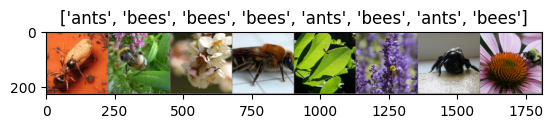

In [16]:
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

imshow(out, title=[class_names[x] for x in preds])

In [17]:
torch.save(model.state_dict(), "./resnet18.pt")